<a href="https://colab.research.google.com/github/mk7890/Industrial-Equipment-Fault-Detection-Machine-Learning-1-Capstone-Project/blob/main/ML1_Capstone_Industrial_equipment_fault_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In modern industrial settings, ensuring the optimal performance and reliability of equipment is critical to reducing downtime, enhancing operational efficiency, and minimizing maintenance costs. As industries increasingly rely on sophisticated machinery, the ability to detect faults in real-time becomes an essential aspect of preventive maintenance strategies. The traditional approach of scheduled maintenance is often inefficient, as it may result in either unnecessary maintenance or the failure to address faults before they lead to equipment breakdowns.

This project focuses on developing a machine learning model to predict faults in industrial equipment, based on a dataset that captures various operational parameters and sensor readings from various equipment over different locations. By leveraging data-driven techniques, we aim to create a model that can accurately classify whether equipment is in a normal operational state or if a fault is likely to occur.

The dataset comprises various features: equipment type, location and sensor measurements for : temperature, pressure, vibration, humidity. Using machine learning algorithms, we will explore different approaches to classification, evaluate model performance using metrics such as precision, recall, and F1-score, and identify the most effective model for fault detection.

The ultimate goal of this project is to contribute to the development of a robust fault detection system that can assist industries in proactively managing maintenance, optimizing resource allocation, and reducing the risk of unexpected equipment failures. By demonstrating the potential of machine learning in this domain, we aim to provide valuable insights into how predictive analytics can enhance the reliability and efficiency of industrial systems

# IMPORTING LIBRARIES

In [106]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import plot
from IPython.display import IFrame

# Preprocessing and Modeling Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
import itertools
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    auc,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve
)

# LOADING THE DATASET

Downloading the Dataset from Kaggle

In [107]:
!kaggle datasets download -d dnkumars/industrial-equipment-monitoring-dataset

Dataset URL: https://www.kaggle.com/datasets/dnkumars/industrial-equipment-monitoring-dataset
License(s): apache-2.0
industrial-equipment-monitoring-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


Extracting the Dataset

In [108]:
import zipfile
zipfile_path = '/content/industrial-equipment-monitoring-dataset.zip'
csv_file = zipfile_path.replace('zip', '')
with zipfile.ZipFile(zipfile_path, 'r') as file:
  file.extractall()
  print('Done')

Done


Creating a Pandas Dataframe

In [109]:
dataframe=pd.read_csv("/content/equipment_anomaly_data.csv")
dataframe.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.180180,25.029278,0.606516,45.694907,Turbine,Atlanta,0.0
1,75.740712,22.954018,2.338095,41.867407,Compressor,Chicago,0.0
2,71.358594,27.276830,1.389198,58.954409,Turbine,San Francisco,0.0
3,71.616985,32.242921,1.770690,40.565138,Pump,Atlanta,0.0
4,66.506832,45.197471,0.345398,43.253795,Pump,New York,0.0


Rounding off Float Valuesto Two Decimal Places

In [110]:
dataframe["temperature"]=dataframe["temperature"].round(2)
dataframe["pressure"]=dataframe["pressure"].round(2)
dataframe["vibration"]=dataframe["vibration"].round(2)
dataframe["humidity"]=dataframe["humidity"].round(2)
dataframe.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.18,25.03,0.61,45.69,Turbine,Atlanta,0.0
1,75.74,22.95,2.34,41.87,Compressor,Chicago,0.0
2,71.36,27.28,1.39,58.95,Turbine,San Francisco,0.0
3,71.62,32.24,1.77,40.57,Pump,Atlanta,0.0
4,66.51,45.20,0.35,43.25,Pump,New York,0.0


# EXPLORATORY DATA ANALYSIS (EDA)

In [111]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7672 non-null   float64
 1   pressure     7672 non-null   float64
 2   vibration    7672 non-null   float64
 3   humidity     7672 non-null   float64
 4   equipment    7672 non-null   object 
 5   location     7672 non-null   object 
 6   faulty       7672 non-null   float64
dtypes: float64(5), object(2)
memory usage: 419.7+ KB


In [112]:
dataframe.isnull().sum()

,0
temperature,0
pressure,0
vibration,0
humidity,0
equipment,0
location,0
faulty,0


In [113]:
dataframe.describe()

,temperature,pressure,vibration,humidity,faulty
count,7672.000000,7672.000000,7672.000000,7672.000000,7672.000000
mean,70.922419,35.738015,1.611889,50.016575,0.099974
std,16.200082,10.381654,0.728573,11.841468,0.299985
min,10.270000,3.620000,-0.430000,10.220000,0.000000
25%,62.775000,29.490000,1.170000,42.615000,0.000000
50%,70.160000,35.230000,1.530000,50.025000,0.000000
75%,77.570000,41.160000,1.920000,57.340000,0.000000
max,149.690000,79.890000,4.990000,89.980000,1.000000


## ploting histograms for each column to visualize distributions

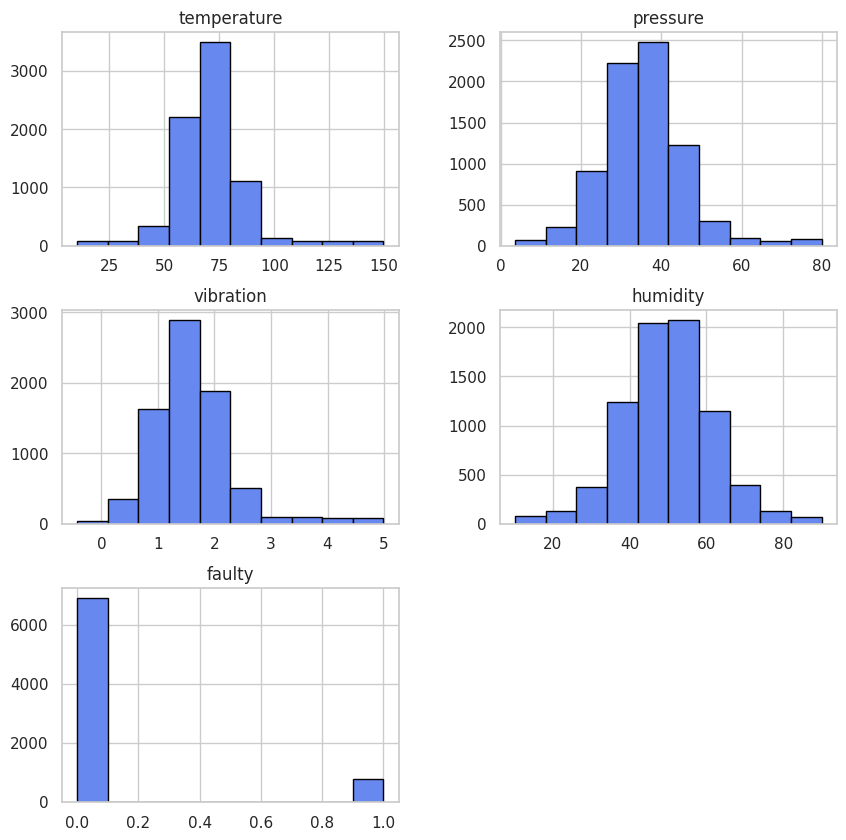

In [114]:
dataframe.hist(figsize=(10,10), edgecolor="black")
plt.show()

In [115]:
dataframe.columns


Index(['temperature', 'pressure', 'vibration', 'humidity', 'equipment',
       'location', 'faulty'],
      dtype='object')

## Pairplot for bivariate scatter plot distributions

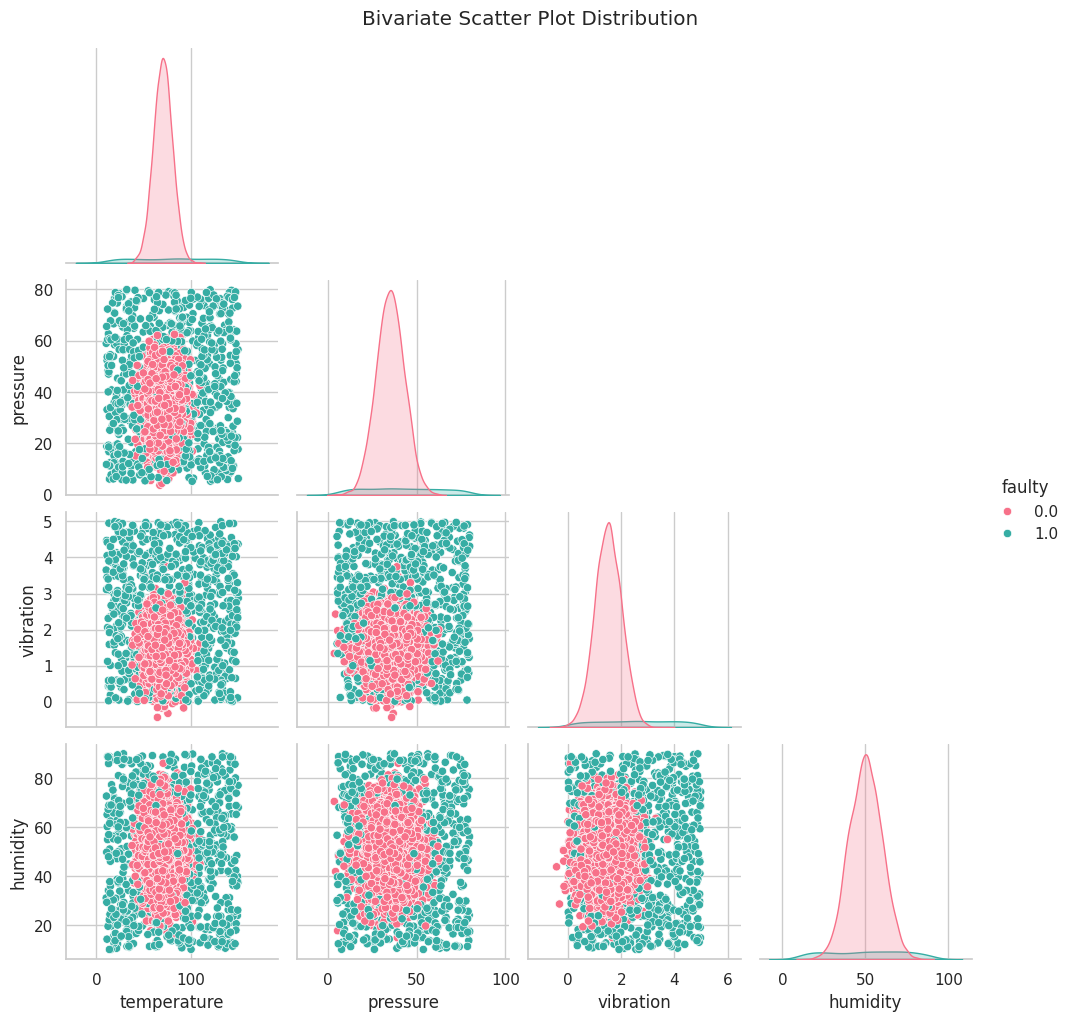

In [116]:
columns_to_plot = ['temperature', 'pressure', 'vibration', 'humidity', 'equipment','location', 'faulty']  # columns you want to plot

sns.pairplot(dataframe[columns_to_plot], diag_kind='kde', hue='faulty', palette='husl', corner=True)
plt.suptitle('Bivariate Scatter Plot Distribution', y=1.02)
plt.show()

<Figure size 6250x6250 with 0 Axes>

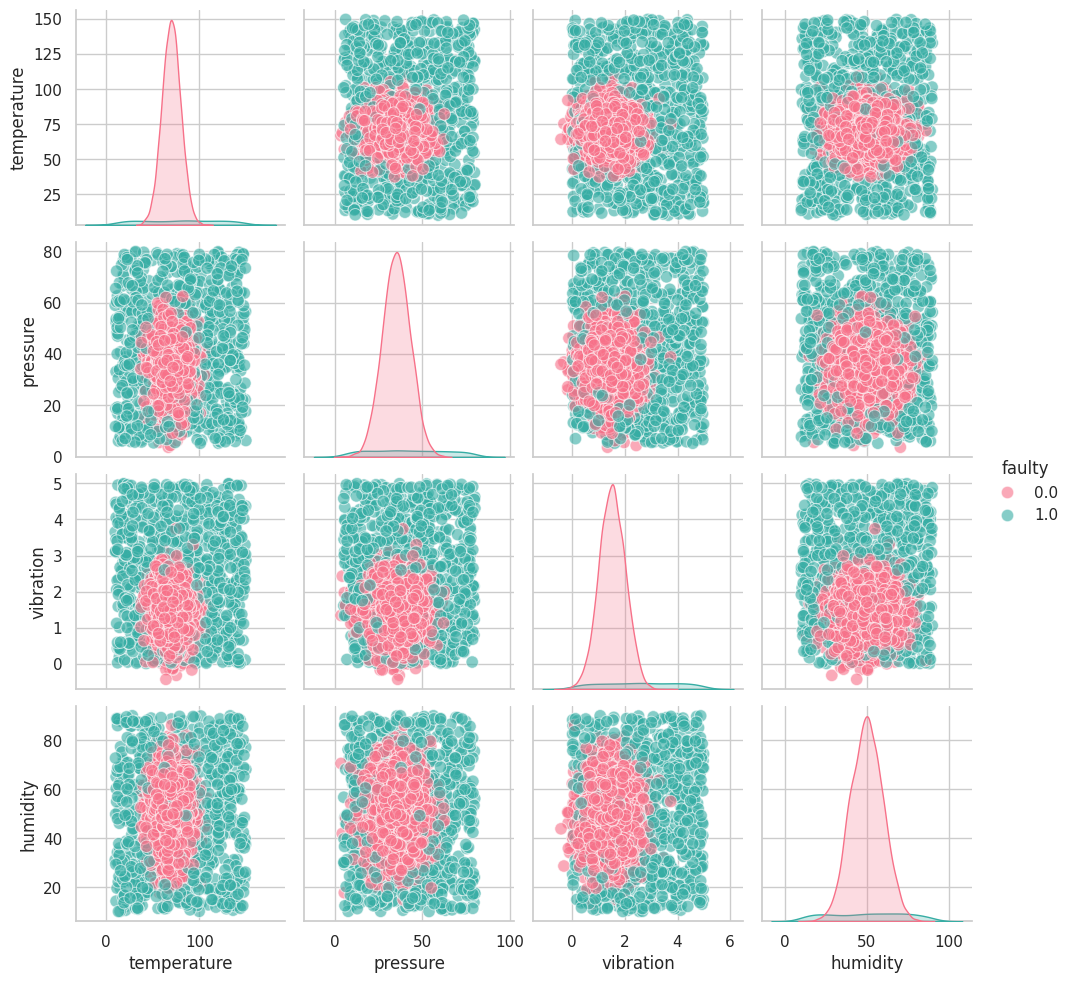

In [117]:
# observe for the float_data
plt.figure(figsize=(25, 25), dpi=250)
sns.set(style="whitegrid")  # Set the plot style
sns.set_palette("coolwarm")    # Set the color palette
sns.pairplot(dataframe.select_dtypes("number"), hue='faulty', palette='husl', plot_kws={'alpha': 0.6, 's': 80})

## Imbalanced Fault Classification Distribution

Text(0, 0.5, 'Count')

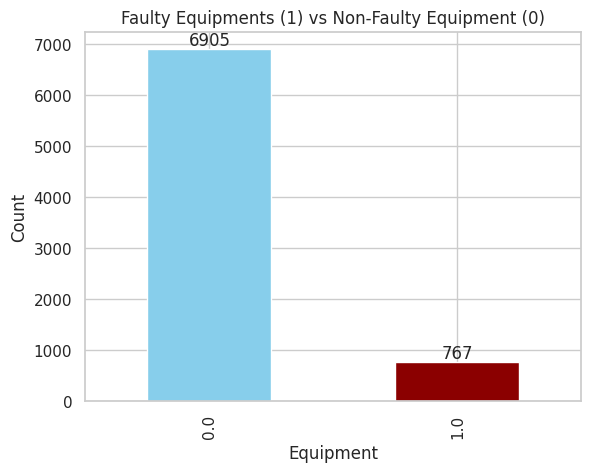

In [118]:
faulty_equipments=dataframe["faulty"].value_counts()
faulty_equipments.plot(kind="bar",color=['skyblue','darkred'])
for i,values in enumerate(faulty_equipments):
     plt.text(i,values,str(values),ha="center",va="bottom")

plt.title("Faulty Equipments (1) vs Non-Faulty Equipment (0)")
plt.xlabel("Equipment")
plt.ylabel("Count")

## Equipment Type Distribution

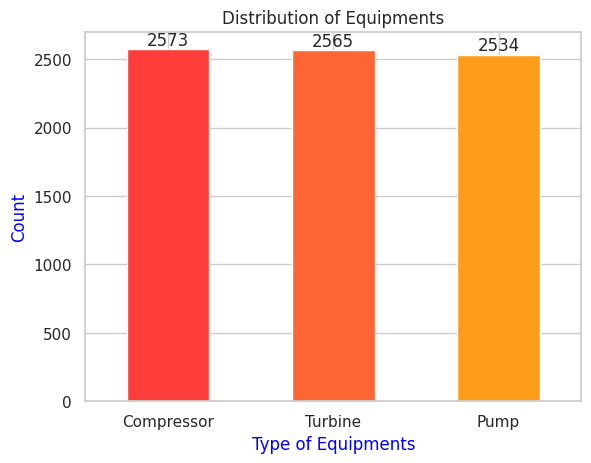

In [119]:
equipments = dataframe["equipment"].value_counts()
colors=['#FF3E3B', '#FF6633', '#FF9C19']
equipments.plot(kind="bar",color=colors)
for i,values in enumerate(equipments):
    plt.text(i,values,str(values),ha="center",va="bottom")

plt.xticks(rotation=0)
plt.xlabel("Type of Equipments",color="blue")
plt.ylabel("Count",font="arial",color="blue")
plt.title("Distribution of Equipments")
plt.show()

## Total Equipment Distribution by Location

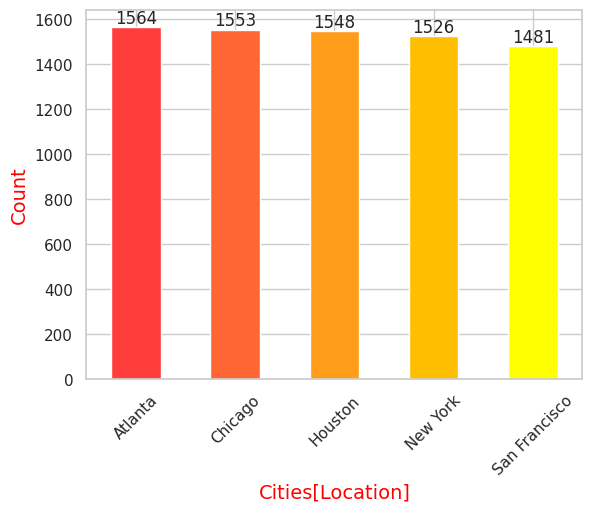

In [120]:
location_l=dataframe["location"].value_counts()
colors = ['#FF3E3B', '#FF6633', '#FF9C19', '#FFBF00', '#FFFF00']
location_l.plot(kind="bar",color=colors)
for i,values in enumerate(location_l):
    plt.text(i,values,str(values),ha="center",va="bottom")

plt.xlabel("Cities[Location]",color="red",fontsize=14)
plt.ylabel("Count",color="red",fontsize=14)
plt.xticks(rotation=45)
plt.show()

## Outliers Visualization

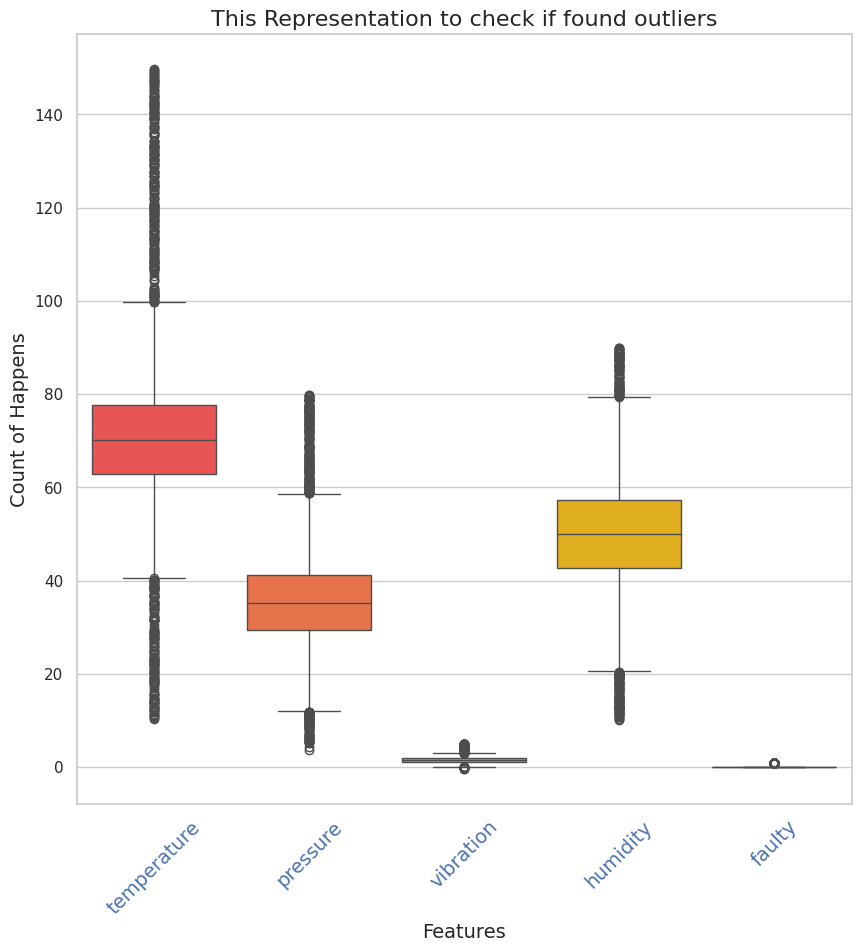

In [121]:
# Color palette
colors = ['#FF3E3B', '#FF6633', '#FF9C19', '#FFBF00', '#FFFF00']

# Plot
plt.figure(figsize=(10, 10))
plt.title("This Representation to check if found outliers", fontsize=16)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Count of Happens", fontsize=14)
plt.xticks(rotation=45, color="b", fontsize=14)
sns.boxplot(data=dataframe, palette=colors)  # Apply the palette
#plt.legend(title="Outliers", prop={'size': 5})  # Legend not applicable without `hue`, will warn
plt.show()

# DATA PREPROCESSING

## Feature Engineering

## Encoding

One-hot encoding will be used to encode the 'equipment' and 'location' columns because it's fast and the columns don't contain high cardinality data

In [122]:
# one hot encoding equipment and location columns
dataframe=pd.get_dummies(dataframe,columns=["equipment","location"])
# convert boolean columns to ones and zeroes
dataframe = dataframe.replace({True: 1, False: 0})
dataframe.head()

<ipython-input-122-632b1ffa18b3>:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,temperature,pressure,vibration,humidity,faulty,equipment_Compressor,equipment_Pump,equipment_Turbine,location_Atlanta,location_Chicago,location_Houston,location_New York,location_San Francisco
0,58.18,25.03,0.61,45.69,0.0,0,0,1,1,0,0,0,0
1,75.74,22.95,2.34,41.87,0.0,1,0,0,0,1,0,0,0
2,71.36,27.28,1.39,58.95,0.0,0,0,1,0,0,0,0,1
3,71.62,32.24,1.77,40.57,0.0,0,1,0,1,0,0,0,0
4,66.51,45.20,0.35,43.25,0.0,0,1,0,0,0,0,1,0


## Train-Test Split

A 60-20-20 dataset split was used to divide the dataset into three parts:

- Training set (60%) - Used to train the model.
- Validation set (20%) - Used to tune the model's hyperparameters and evaluate its performance during training.
- Test set (20%) - Used to evaluate the final model's performance on unseen data.

This split ensures that the model is tested on completely unseen data after being optimized on the validation set, providing an unbiased estimate of its performance.

In [123]:
# dropping the target column in the dataset.
X = dataframe.drop('faulty', axis=1)
y = dataframe['faulty']

# Splitting the data into training (60%), validation (20%), and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

## Applying SMOTE (Synthetic Minority Oversappling Technique) on the Training data only

In [124]:
# Applying SMOTE only to the training set
smote = SMOTE(random_state=42)

Robust scaling
- This method is used to handle outliers better than standardization or normalization. It's based on percentiles, like the median and the interquartile range (IQR).

Mean normalization
- This technique is used when the data has a known range but varies around the mean. It centers the data around the mean and scales it between -1 and 1.


In [125]:
# Columns for scaling
robust_cols = ["humidity", "temperature", "pressure"]
minmax_cols = ["vibration"]

# Column transformer for scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('robust', RobustScaler(), robust_cols),
        ('minmax', MinMaxScaler(), minmax_cols)
    ],
    remainder='passthrough'  # Keeps other columns unchanged
)

# MODEL TRAINING

Random Forest Classifier was used because:

## Random Forest Classifier

In [126]:
# Random Forest Classification without Hyperparameter Tuning
# Defining the pipeline
pipeline = ImbPipeline([
    ('smote', smote),
    ('scaler', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [127]:
# Fitting the pipeline on the training data
pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/compose/_column_transformer.py:1651: FutureWarning:


The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).




Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('robust', RobustScaler(),
                                                  ['humidity', 'temperature',
                                                   'pressure']),
                                                 ('minmax', MinMaxScaler(),
                                                  ['vibration'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [128]:
# Evaluating the model on validation data
y_val_pred = pipeline.predict(X_val)
y_val_prob = pipeline.predict_proba(X_val)[:, 1]

In [129]:
# Validation metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_prob)
conf_matrix = confusion_matrix(y_val, y_val_pred)

In [130]:
print("Validation Metrics (Without Hyperparameter Tuning):")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
# Classification report for validation data
print("\nClassification Report (Validation - Without Hyperparameter Tuning):")
print(classification_report(y_val, y_val_pred))
print("\nConfusion Matrix:")
print(conf_matrix)

Validation Metrics (Without Hyperparameter Tuning):
Accuracy: 0.98
Precision: 0.87
Recall: 0.88
F1 Score: 0.88
ROC AUC: 0.98

Classification Report (Validation - Without Hyperparameter Tuning):
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1381
         1.0       0.87      0.88      0.88       153

    accuracy                           0.98      1534
   macro avg       0.93      0.93      0.93      1534
weighted avg       0.98      0.98      0.98      1534


Confusion Matrix:
[[1361   20]
 [  18  135]]


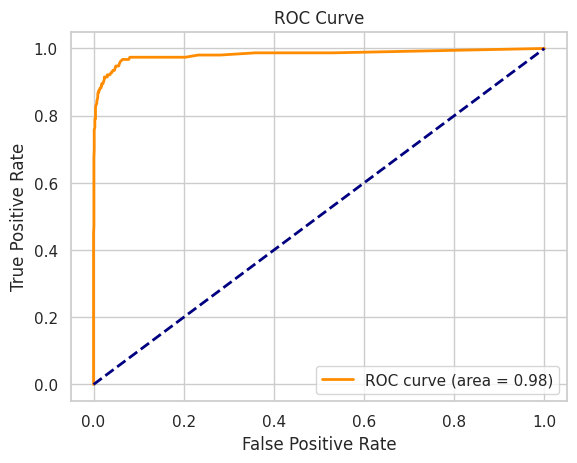

In [131]:
# Plotting the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [132]:
# Testing the model on the test data
y_test_pred = pipeline.predict(X_test)
y_test_prob = pipeline.predict_proba(X_test)[:, 1]

In [133]:
# Test metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

In [134]:
print("\nTest Metrics (Without Hyperparameter Tuning):")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1 Score: {test_f1:.2f}")
print(f"ROC AUC: {test_roc_auc:.2f}")
# Classification report for test data
print("\nClassification Report (Test - Without Hyperparameter Tuning):")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:")
print(test_conf_matrix)


Test Metrics (Without Hyperparameter Tuning):
Accuracy: 0.98
Precision: 0.88
Recall: 0.88
F1 Score: 0.88
ROC AUC: 0.99

Classification Report (Test - Without Hyperparameter Tuning):
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1381
         1.0       0.88      0.88      0.88       154

    accuracy                           0.98      1535
   macro avg       0.93      0.93      0.93      1535
weighted avg       0.98      0.98      0.98      1535


Confusion Matrix:
[[1363   18]
 [  19  135]]


## Hyperparameter Tuning with RandomizedSearchCV

In [135]:
# Hyperparameter tuning
param_dist = {
    'classifier__n_estimators': [50, 100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [136]:
# Performing RandomizedSearchCV for best parameters
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=50, cv=3, scoring='f1', random_state=42, verbose=2, n_jobs=-1)
random_search.fit(X_train, y_train)
print("done")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
done


In [137]:
# Best parameters and model
best_params = random_search.best_params_
print("\nBest Parameters:")
print(best_params)

best_model = random_search.best_estimator_
print("done")


Best Parameters:
{'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 20}
done


In [138]:
# Evaluating the best model on validation data
y_val_pred = best_model.predict(X_val)
y_val_prob = best_model.predict_proba(X_val)[:, 1]
print("done")

done


In [139]:
# Validation metrics (After Hyperparameter Tuning)
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_prob)
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("done")

done


In [140]:
print("\nValidation Metrics (After Hyperparameter Tuning):")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Classification report for validation data
print("\nClassification Report (Validation - After Hyperparameter Tuning):")
print(classification_report(y_val, y_val_pred))


Validation Metrics (After Hyperparameter Tuning):
Accuracy: 0.97
Precision: 0.86
Recall: 0.88
F1 Score: 0.87
ROC AUC: 0.98

Confusion Matrix:
[[1360   21]
 [  19  134]]

Classification Report (Validation - After Hyperparameter Tuning):
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1381
         1.0       0.86      0.88      0.87       153

    accuracy                           0.97      1534
   macro avg       0.93      0.93      0.93      1534
weighted avg       0.97      0.97      0.97      1534



In [141]:
# Testing the model on the test data
y_test_pred = best_model.predict(X_test)
y_test_prob = best_model.predict_proba(X_test)[:, 1]
print("done")

done


In [142]:
# Test metrics (After Hyperparameter Tuning)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_prob)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
print("done")

done


In [143]:
print("\nTest Metrics (After Hyperparameter Tuning):")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1 Score: {test_f1:.2f}")
print(f"ROC AUC: {test_roc_auc:.2f}")
print("\nConfusion Matrix:")
print(test_conf_matrix)
# Classification report for test data
print("\nClassification Report (Test - After Hyperparameter Tuning):")
print(classification_report(y_test, y_test_pred))


Test Metrics (After Hyperparameter Tuning):
Accuracy: 0.98
Precision: 0.89
Recall: 0.88
F1 Score: 0.89
ROC AUC: 0.99

Confusion Matrix:
[[1365   16]
 [  19  135]]

Classification Report (Test - After Hyperparameter Tuning):
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1381
         1.0       0.89      0.88      0.89       154

    accuracy                           0.98      1535
   macro avg       0.94      0.93      0.94      1535
weighted avg       0.98      0.98      0.98      1535



In [144]:
# Saving the model
import joblib
joblib.dump(best_model, 'industrial_equipment_fault_detection_best_model.pkl')
print("Model saved successfully!")

Model saved successfully!


# Model Analysis and Conclusion

For industrial equipment fault detection modeling, selecting the best classification metric depends on the specific nature of the problem and the consequences of false positives and false negatives. However, here are some commonly used classification metrics:

1. Precision
Use case: When false positives (incorrectly predicting a fault when there is none) have high consequences (e.g., unnecessary maintenance or shutdowns).

2. Recall (Sensitivity or True Positive Rate)
Use case: When false negatives (failing to detect a fault when it occurs) are more critical (e.g., undetected faults leading to equipment failure or catastrophic events).

3. F1-Score
Use case: When you need to balance precision and recall, especially if both false positives and false negatives are important to minimize.

4. Area Under the Receiver Operating Characteristic Curve (AUC-ROC)
Use case: For models with imbalanced classes, as it evaluates the ability of the classifier to discriminate between the two classes (fault vs. no fault).
Interpretation: A higher AUC indicates a better performing model, where the model is good at distinguishing between faults and normal states.

5. Confusion Matrix
Use case: Provides a comprehensive summary of model performance with respect to true positives, true negatives, false positives, and false negatives. This helps in understanding how many faults are correctly identified, how many non-faults are missed, and so on.

**Recommendations:**

For Fault Detection (with Imbalanced Data): - Typically, Recall (Sensitivity) or F1-Score are ideal metrics because it's crucial not to miss any faults (false negatives). This is the Metric to emphasize on the most in this case.
- For Minimizing False Alarms (False Positives): Precision would be a better choice if false positives lead to high operational costs, like unnecessary maintenance or downtimes.
- For a Balanced Approach: F1-Score balances recall and precision, making it a solid choice for many fault detection problems.
- For General Classification: If the data is balanced and you want an overall measure of model performance, AUC-ROC is a good choice (not suitable for this scenario).